# <center><B>MSCA-31006 <span style="color:maroon">Time Series Analysis and Forecasting</span></B></center>
## <center><B><U><i>Final Project</i></U></B></center>&nbsp; <center><i>Data Input and Engineering</i></center>

In [98]:
library(tseries)
library(TSA)
library(fpp)
library(fpp2)
library(ggplot2)
library(forecast)

<br>

<h3><u>Read and Clean the Data</u></h3>

This set has 13 files overall, with historical information for energy sources going back to the 1970's. Most of the data has monthly frequency but a few datasets are yearly.

In [99]:
path <- paste(getwd(), "/Data/", sep = "")
files <- dir(path, pattern = ".csv")
# Drop last file to deal with later
files <- files[-1]

In [100]:
files

[1] "Table_1.2_Primary_Energy_Production_by_Source.csv"                                                       
 [2] "Table_1.3_Primary_Energy_Consumption_by_Source.csv"                                                      
 [3] "Table_1.7_Primary_Energy_Consumption_-_Energy_Expenditures_-_and_Carbon_Dioxide_Emissions_Indicators.csv"
 [4] "Table_10.1_Renewable_Energy_Production_and_Consumption_by_Source.csv"                                    
 [5] "Table_11.1_Carbon_Dioxide_Emissions_From_Energy_Consumption_by_Source.csv"                               
 [6] "Table_11.6_Carbon_Dioxide_Emissions_From_Energy_Consumption__Electric_Power_Sector.csv"                  
 [7] "Table_2.1_Energy_Consumption_by_Sector.csv"                                                              
 [8] "Table_2.6_Electric_Power_Sector_Energy_Consumption.csv"                                                  
 [9] "Table_7.1_Electricity_Overview.csv"                                                                      
[10] "Table_7.2b_Electricity_Net_Generation__Electric_Power_Sector.csv"                                        
[11] "Table_9.10_Natural_Gas_Prices.csv"                                                                       
[12] "Table_9.8_Average_Retail_Prices_of_Electricity.csv"                                                      
[13] "Table_9.9_Cost_of_Fossil-Fuel_Receipts_at_Electric_Generating_Plants.csv"                                
[14] "Table_C1_Population_-_U.S._Gross_Domestic_Product_-_and_U.S._Gross_Output.csv"

In [101]:
energy_data <- list()
metadata <- list()
i <- 1

for (file in files) {
    # Read the header
    header <- read.csv(paste(path, file, sep = ""), skip = 10, nrows = 1, header = F, as.is = T)
    # Find the units
    units <- read.csv(paste(path, file, sep = ""), skip = 11, nrows = 1, header = F, as.is = T)
    # Read the data
    dta <- read.csv(paste(path, file, sep = ""), skip = 12, header = F, check.names = T, blank.lines.skip = T, na.strings = "Not Available")

    # Make sure values are numeric
    dta[,2:ncol(dta)] <- sapply(dta[,2:ncol(dta)], function(x) trimws(x))  # get rid of whitespace
    suppressWarnings(dta[,2:ncol(dta)] <- sapply(dta[,2:ncol(dta)], function(x) as.numeric(x)))
    # Also substitute negative values with zeros
    dta[,2:ncol(dta)] <- sapply(dta[,2:ncol(dta)], function(x) (abs(x) + x)/2)
    # Convert energy units to Trillion Btu if other                           
    dta[,which(units == '(Quadrillion Btu)')] <- sapply(dta[,which(units == '(Quadrillion Btu)')], function(x) 1000*x)                               
    units[which(units == '(Quadrillion Btu)')] <- '(Trillion Btu)'  # update metadata
    dta[,which(units == '(Million Kilowatthours)')] <- sapply(dta[,which(units == '(Million Kilowatthours)')], function(x) (3.412e-3)*x)                               
    units[which(units == '(Million Kilowatthours)')] <- '(Trillion Btu)'  # update metadata 

    # Assign to the list
    energy_data[[i]] <- dta
    metadata[[i]] <- rbind(header, units)
    i <- i+1
}

set_names <- c("Prod_by_Source", 
               "Consump_by_Source", 
               "Expenditures_Emissions_Indicators", 
               "Renewable_by_Source", 
               "CO2_by_Source", 
               "CO2_ElecPower", 
               "Consump_by_Sector",
               "Consump_Elec",
               "ElectricityOverview",
               "Elec_by_Source",
               "NGPrices", 
               "Avg_Elec_Price", 
               "Fossil_Fuel_Costs", 
               "GDP_Pop_Info")

                                
names(energy_data) <- set_names
names(metadata) <- set_names

<br>

<h4><b>Example Output</b></h4>

Use the `metadata` list to get information about the variables and their units. Be sure to match the name of the dataframe with the corresponding item in the metadata list to obtain the correct information.

In [102]:
rbind(metadata$Renewable_by_Source, head(energy_data$Renewable_by_Source))

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Month,Wood Energy Production,Biofuels Production,Total Biomass Energy Production,Total Renewable Energy Production,Hydroelectric Power Consumption,Geothermal Energy Consumption,Solar Energy Consumption,Wind Energy Consumption,Wood Energy Consumption,Waste Energy Consumption,Biofuels Consumption,Total Biomass Energy Consumption,Total Renewable Energy Consumption
NA,(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu)
01/01/1973,129.63,NA,129.787,403.981,272.703,1.491,NA,NA,129.63,0.157,NA,129.787,403.981
02/01/1973,117.194,NA,117.338,360.9,242.199,1.363,NA,NA,117.194,0.144,NA,117.338,360.9
03/01/1973,129.763,NA,129.938,400.161,268.81,1.412,NA,NA,129.763,0.176,NA,129.938,400.161
04/01/1973,125.462,NA,125.636,380.47,253.185,1.649,NA,NA,125.462,0.174,NA,125.636,380.47
05/01/1973,129.624,NA,129.834,392.141,260.77,1.537,NA,NA,129.624,0.21,NA,129.834,392.141
06/01/1973,125.435,NA,125.611,377.232,249.859,1.763,NA,NA,125.435,0.176,NA,125.611,377.232


In [103]:
rbind(metadata$Expenditures_Emissions_Indicators, energy_data$Expenditures_Emissions_Indicators[30:35,])

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Year,Total Primary Energy Consumption,Total Primary Energy Consumption per Capita,Total Primary Energy Consumption per Real Dollar of GDP,Energy Expenditures,Energy Expenditures per Capita,Energy Expenditures as Share of GDP,Energy Expenditures as Share of Gross Output,Total Energy CO2 Emissions,Total Energy CO2 Emissions per Capita,Total Energy CO2 Emissions per Real Dollar of GDP
2,NA,(Trillion Btu),(Million Btu),(Thousand Btu per Chained (2012) Dollar),(Million Nominal Dollars),(Nominal Dollars),(Percent),(Percent),(Million Metric Tons Carbon Dioxide),(Metric Tons Carbon Dioxide),(Metric Tons Carbon Dioxide per Million Chained (2012) Dollars)
30,1978,79906.703,359,12.16,239280.18,1075,10.2,5.5,4883.91,21.9,744
31,1979,80811.788,359,11.93,297574.63,1322,11.3,6,4946.627,22,730
32,1980,78021.113,343,11.54,374350.01,1647,13.1,6.9,4750.409,20.9,703
33,1981,76057.187,331,10.97,427901.18,1865,13.3,7.1,4627.298,20.2,668
34,1982,73046.189,315,10.73,426482.04,1841,12.8,6.9,4394.16,19,646
35,1983,72915.394,312,10.24,417621.52,1786,11.5,6.3,4370.655,18.7,614


<br>

In [104]:
rbind(metadata$GDP_Pop_Info, tail(energy_data$GDP_Pop_Info))

,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Year,"Total Resident Population, United States","Total Resident Population, World",United States Share of World Population,"U.S. Gross Domestic Product, Nominal","U.S. Gross Domestic Product, Real",U.S. Gross Domestic Product Implicit Price Deflator,"U.S. Gross Output, Nominal Dollars"
2,NA,(Million people),(Million people),(Percent),(Billion Dollars),(Billion chained (2012) dollars),(2012 = 1.00000),(Billion Dollars)
65,2013,316.1,7109.6,4.4,16784.9,16495.4,1.01755,30291.3
66,2014,318.4,7188.4,4.4,17521.7,16899.8,1.0368,31740
67,2015,320.7,7267,4.4,18219.3,17386.7,1.04789,32176.7
68,2016,323.1,7345.8,4.4,18707.2,17659.2,1.05935,32838.5
69,2017,325.1,7424.2,4.4,19485.4,18050.7,1.07948,34495.4
70,2018,327.2,7503.8,4.4,20494.1,18566.4,1.10382,36593.3


<br>

<h4><b>Generation Information for Illinois</b></h4>

To get this information, filtering and aggregating over the `generation_by_state.csv` data is needed. Note this is monthly data but only goes back to 2001.

In [105]:
IL_data <- read.csv("Data/generation_by_state.csv", header = T, strip.white = T)
head(IL_data)

,YEAR,MONTH,STATE,TYPE.OF.PRODUCER,ENERGY.SOURCE,GENERATION..Megawatthours.
,<int>,<int>,<fct>,<fct>,<fct>,<dbl>
1,2001,1,AK,Total Electric Power Industry,Coal,46903
2,2001,1,AK,Total Electric Power Industry,Petroleum,71085
3,2001,1,AK,Total Electric Power Industry,Natural Gas,367521
4,2001,1,AK,Total Electric Power Industry,Hydroelectric Conventional,104549
5,2001,1,AK,Total Electric Power Industry,Wind,87
6,2001,1,AK,Total Electric Power Industry,Total,590145


In [106]:
IL_data <- IL_data[IL_data$STATE == "IL",]
head(IL_data, 15)

,YEAR,MONTH,STATE,TYPE.OF.PRODUCER,ENERGY.SOURCE,GENERATION..Megawatthours.
,<int>,<int>,<fct>,<fct>,<fct>,<dbl>
414,2001,1,IL,Total Electric Power Industry,Coal,7539572
415,2001,1,IL,Total Electric Power Industry,Petroleum,17066
416,2001,1,IL,Total Electric Power Industry,Natural Gas,137681
417,2001,1,IL,Total Electric Power Industry,Other Gases,28111
418,2001,1,IL,Total Electric Power Industry,Nuclear,8237539
419,2001,1,IL,Total Electric Power Industry,Hydroelectric Conventional,12599
420,2001,1,IL,Total Electric Power Industry,Other Biomass,59136
421,2001,1,IL,Total Electric Power Industry,Other,7665
422,2001,1,IL,Total Electric Power Industry,Total,16039369


We are not interested in the type of producer so we can sum up the generation (total output) over producer type. We can also give the columns more useful labels.

In [107]:
IL_data <- aggregate(GENERATION..Megawatthours. ~  MONTH + YEAR + ENERGY.SOURCE, IL_data, sum)
colnames(IL_data) <- c("Month", "Year", "Source", "Output_MWh")
IL_data <- IL_data[, c(2,1,3,4)]  # flip year, month
head(IL_data, 10)

,Year,Month,Source,Output_MWh
,<int>,<int>,<fct>,<dbl>
1,2001,1,Coal,15079144
2,2001,2,Coal,12535630
3,2001,3,Coal,12548664
4,2001,4,Coal,11287268
5,2001,5,Coal,12377706
6,2001,6,Coal,13591136
7,2001,7,Coal,15519272
8,2001,8,Coal,15965670
9,2001,9,Coal,13145606


<br>

We can subset by wind and solar data for analysis. 

<b>IL Wind Energy</b>

In [108]:
IL_wind <- IL_data[IL_data$Source == 'Wind',]
rownames(IL_wind) <- 1:nrow(IL_wind)
head(IL_wind)

,Year,Month,Source,Output_MWh
,<int>,<int>,<fct>,<dbl>
1,2003,1,Wind,3286
2,2003,2,Wind,2900
3,2003,3,Wind,2984
4,2003,4,Wind,2680
5,2003,5,Wind,2734
6,2003,6,Wind,2900


<br>

<b>IL Solar Energy</b>

In [109]:
IL_solar <- IL_data[IL_data$Source == 'Solar Thermal and Photovoltaic',]
rownames(IL_solar) <- 1:nrow(IL_solar)
head(IL_solar)

,Year,Month,Source,Output_MWh
,<int>,<int>,<fct>,<dbl>
1,2009,1,Solar Thermal and Photovoltaic,0
2,2009,2,Solar Thermal and Photovoltaic,0
3,2009,3,Solar Thermal and Photovoltaic,0
4,2009,4,Solar Thermal and Photovoltaic,0
5,2009,5,Solar Thermal and Photovoltaic,0
6,2009,6,Solar Thermal and Photovoltaic,0


---

<br>

<h3><u>Converting to Time Series Data</u></h3>

Create monthly and yearly lists for to convert to time series. Separate metadata as well for easy reference.

In [110]:
yearly_dta <- energy_data[c('Expenditures_Emissions_Indicators', 'GDP_Pop_Info')]
yearly_meta <- metadata[c('Expenditures_Emissions_Indicators', 'GDP_Pop_Info')]

In [111]:
monthly_dta <- energy_data[setdiff(names(energy_data), names(yearly_dta))]
monthly_meta <- metadata[setdiff(names(energy_data), names(yearly_dta))]

Build time-series:

In [112]:
yearly_dta_ts <- lapply(yearly_dta, function(x) ts(x[2:ncol(x)], start = x[1,1], frequency = 1))

In [113]:
head(yearly_dta_ts$GDP_Pop_Info, 10)

,V2,V3,V4,V5,V6,V7,V8
1949,149.2,NA,NA,272.5,2106.6,0.12935,510.3
1950,152.3,2557.6,6.0,299.8,2289.5,0.13095,577.8
1951,154.9,2594.9,6.0,346.9,2473.8,0.14024,654.6
1952,157.6,2636.8,6.0,367.3,2574.9,0.14266,686.0
1953,160.2,2682.1,6.0,389.2,2695.6,0.14439,739.2
1954,163.0,2730.2,6.0,390.5,2680.0,0.14573,739.9
1955,165.9,2782.1,6.0,425.5,2871.2,0.14819,802.6
1956,168.9,2835.3,6.0,449.4,2932.4,0.15324,841.8
1957,172.0,2891.4,5.9,474.0,2994.1,0.15832,875.5
1958,174.9,2948.2,5.9,481.2,2972.0,0.16192,897.5


<br>

The regex expression in the `start` portion of the `ts` function adjusts for the different formatting and the different starting dates of the data.

In [114]:
monthly_dta_ts <- lapply(monthly_dta, 
                         function(x) { ts(x[2:ncol(x)],
                         start = c(as.integer(regmatches(x[1,1], regexpr("[0-9]{4}", x[1,1]))), 1),
                         frequency = 12) })

In [115]:
head(monthly_dta_ts$CO2_by_Source, 12)

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
Jan 1973,108.256,125.686,0.428,54.556,10.493,13.778,5.160,1.039,70.901,4.743,50.756,8.504,220.358,454.300
Feb 1973,97.667,113.867,0.432,51.207,8.874,12.225,4.421,1.027,67.377,3.904,46.890,7.460,203.817,415.351
Mar 1973,97.333,107.811,0.459,43.975,6.706,12.325,2.551,1.107,75.482,4.260,47.336,8.414,202.615,407.758
Apr 1973,93.052,97.938,0.446,33.602,5.809,12.144,2.006,0.981,73.367,4.087,36.792,7.991,177.227,368.216
May 1973,94.311,92.134,0.549,35.203,5.504,13.792,1.682,1.159,80.052,4.543,38.708,8.445,189.636,376.081
Jun 1973,97.724,81.740,0.471,30.835,4.515,12.070,1.447,1.008,78.103,4.765,38.734,8.591,180.539,360.003
Jul 1973,103.131,82.952,0.420,30.666,4.428,12.975,1.887,1.222,81.395,4.697,37.028,8.820,183.538,369.621
Aug 1973,105.357,84.184,0.668,33.657,5.246,12.990,1.864,1.189,84.101,4.900,42.304,8.907,195.826,385.367
Sep 1973,98.261,81.199,0.462,34.090,5.345,12.841,2.269,1.042,73.806,4.245,39.758,8.064,181.922,361.381
Oct 1973,101.028,90.755,0.550,38.607,6.663,13.667,2.281,1.283,77.383,5.027,39.764,8.351,193.575,385.358


<br>

Convert the <i>Illinois</i> data:

In [116]:
IL_wind_ts <- ts(IL_wind[,'Output_MWh'], start = c(IL_wind[1,1], 1), frequency = 12)
IL_solar_ts <- ts(IL_solar[,'Output_MWh'], start = c(IL_solar[1,1], 1), frequency = 12)

<br>

<h4><u>A Quick Look at Time Series Data Samples</u></h4>

In [117]:
options(repr.plot.width = 11, repr.plot.height = 5)

In [118]:
monthly_meta$Prod_by_Source

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Month,Coal Production,Natural Gas (Dry) Production,Crude Oil Production,Natural Gas Plant Liquids Production,Total Fossil Fuels Production,Nuclear Electric Power Production,Hydroelectric Power Production,Geothermal Energy Production,Solar Energy Production,Wind Energy Production,Biomass Energy Production,Total Renewable Energy Production,Total Primary Energy Production
NA,(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu),(Trillion Btu)


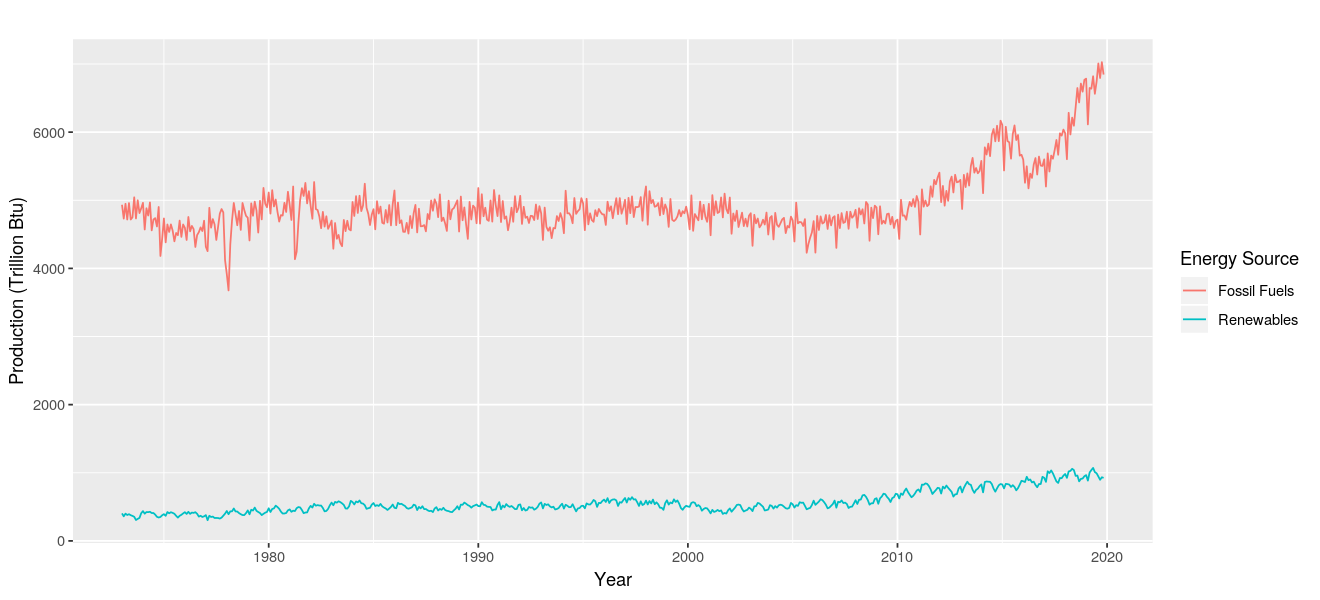

In [119]:
autoplot(cbind("Fossil Fuels"  = monthly_dta_ts$Prod_by_Source[,"V6"], 
               "Renewables" = monthly_dta_ts$Prod_by_Source[,"V13"])) + 
                xlab("Year") + ylab("Production (Trillion Btu)") + guides(color = guide_legend(title = "Energy Source"))

Renewables have a looong way to go...

<br>

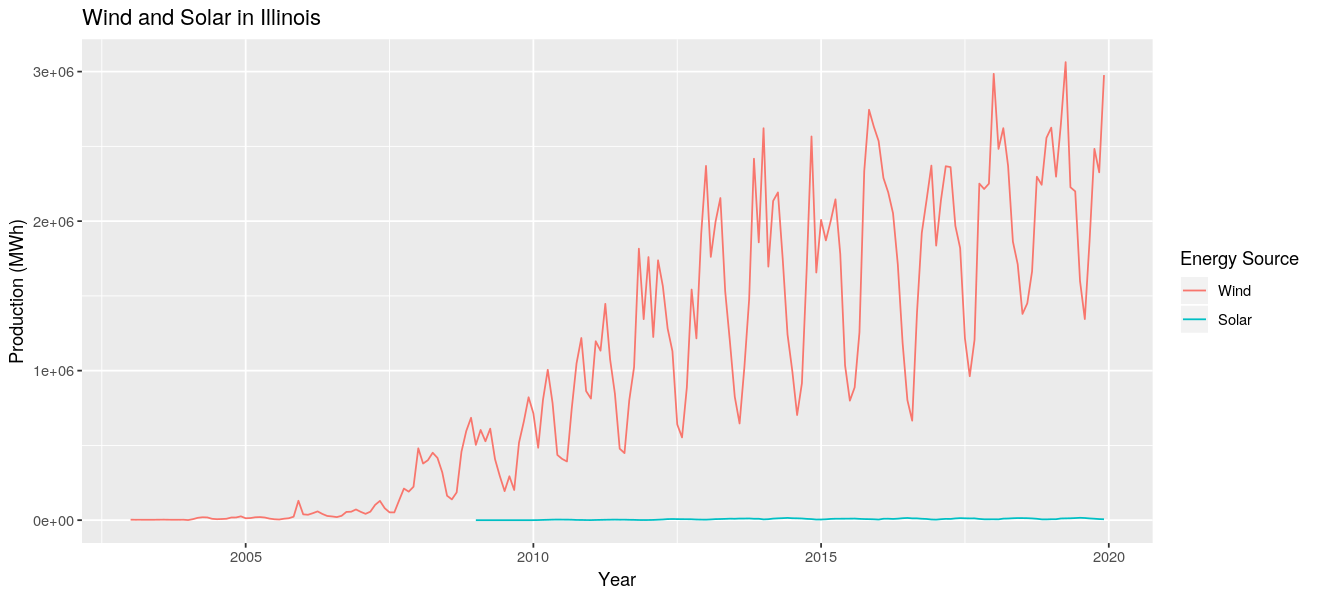

In [120]:
autoplot(cbind("Wind"  = IL_wind_ts, "Solar" = IL_solar_ts)) + 
                xlab("Year") + ylab("Production (MWh)") + ggtitle("Wind and Solar in Illinois") +
                guides(color = guide_legend(title = "Energy Source"))

It should not be surprising to see that wind is doing much better as a source of energy in IL compared to solar power.

<br>

<h4><u>Save the Data for Reuse</u></h4>

In [121]:
save(monthly_dta, monthly_meta, file = "Monthly_Data.RData")
save(yearly_dta, yearly_meta, file = "Yearly_Data.RData")
save(IL_data, IL_solar, IL_wind, IL_wind_ts, IL_solar_ts, file = "IL_Data.RData")
save(monthly_dta_ts, yearly_dta_ts, file = "Time_Series.RData")

---

<br>

<h3><b>Installed Capacity Data</b></h3>

In [25]:
capacity <- read.csv(file = "Data/EIA/december2019_installedCapacity.csv", skip = 1, header = T, fill = T)
head(capacity)

,Entity.ID,Entity.Name,Plant.ID,Plant.Name,Sector,Plant.State,Generator.ID,Unit.Code,Nameplate.Capacity..MW.,Net.Summer.Capacity..MW.,⋯,Planned.Derate.of.Summer.Capacity..MW.,Planned.Uprate.Year,Planned.Uprate.Month,Planned.Uprate.of.Summer.Capacity..MW.,County,Latitude,Longitude,Google.Map,Bing.Map,Balancing.Authority.Code
,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<dbl>,<int>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,195,Alabama Power Co,2,Bankhead Dam,Electric Utility,AL,1,,53.9,53.0,⋯,NA,NA,NA,NA,Tuscaloosa,33.45867,-87.35682,Map,Map,SOCO
2,195,Alabama Power Co,3,Barry,Electric Utility,AL,1,,153.1,55.5,⋯,NA,NA,NA,NA,Mobile,31.00690,-88.01030,Map,Map,SOCO
3,195,Alabama Power Co,3,Barry,Electric Utility,AL,2,,153.1,55.5,⋯,NA,NA,NA,NA,Mobile,31.00690,-88.01030,Map,Map,SOCO
4,195,Alabama Power Co,3,Barry,Electric Utility,AL,4,,403.7,362.0,⋯,NA,NA,NA,NA,Mobile,31.00690,-88.01030,Map,Map,SOCO
5,195,Alabama Power Co,3,Barry,Electric Utility,AL,5,,788.8,756.5,⋯,NA,NA,NA,NA,Mobile,31.00690,-88.01030,Map,Map,SOCO
6,195,Alabama Power Co,3,Barry,Electric Utility,AL,A1CT,G521,170.1,175.6,⋯,NA,NA,NA,NA,Mobile,31.00690,-88.01030,Map,Map,SOCO


<br>
We only need a few of these columns for analysis:

In [26]:
# print(colnames(capacity))
columns <- colnames(capacity)[c(4:6, 9, 12:13, 15:16, 19)]  # columns of interest
print(columns)

[1] "Plant.Name"              "Sector"                 
[3] "Plant.State"             "Nameplate.Capacity..MW."
[5] "Technology"              "Energy.Source.Code"     
[7] "Operating.Month"         "Operating.Year"         
[9] "Status"                 


In [27]:
# Use the selected columns and rename for readability
capacity <- capacity[, columns]
colnames(capacity)[c(1,3,4,6)] <- c("Name", "State", "Capacity.MW", "Source")
capacity$Capacity.MW <- as.numeric(as.character(capacity$Capacity.MW))

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [28]:
head(capacity)

,Name,Sector,State,Capacity.MW,Technology,Source,Operating.Month,Operating.Year,Status
,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<int>,<int>,<fct>
1,Bankhead Dam,Electric Utility,AL,53.9,Conventional Hydroelectric,WAT,7,1963,(OP) Operating
2,Barry,Electric Utility,AL,153.1,Natural Gas Steam Turbine,NG,2,1954,(OP) Operating
3,Barry,Electric Utility,AL,153.1,Natural Gas Steam Turbine,NG,7,1954,(OP) Operating
4,Barry,Electric Utility,AL,403.7,Conventional Steam Coal,BIT,12,1969,(OP) Operating
5,Barry,Electric Utility,AL,788.8,Conventional Steam Coal,BIT,10,1971,(OP) Operating
6,Barry,Electric Utility,AL,170.1,Natural Gas Fired Combined Cycle,NG,5,2000,(OP) Operating


Using `unique(capacity$Source)` shows that wind energy has the code "WND" and solar energy is "SUN". Next, subset the data into wind energy and solar energy installed capacity.

<h3><u>Wind Energy</u></h3>

In [29]:
wind_cap <- capacity[capacity$Source == "WND",]
head(wind_cap)

,Name,Sector,State,Capacity.MW,Technology,Source,Operating.Month,Operating.Year,Status
,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<int>,<int>,<fct>
193,Snake River,Electric Utility,AK,0.8,Onshore Wind Turbine,WND,1,2015,(OP) Operating
194,Snake River,Electric Utility,AK,0.9,Onshore Wind Turbine,WND,7,2013,(OP) Operating
195,Snake River,Electric Utility,AK,0.9,Onshore Wind Turbine,WND,7,2013,(OP) Operating
882,Lamar Plant,Electric Utility,CO,4.5,Onshore Wind Turbine,WND,2,2004,(OP) Operating
883,Lamar Plant,Electric Utility,CO,1.5,Onshore Wind Turbine,WND,2,2004,(OP) Operating
1184,Medicine Bow,IPP Non-CHP,WY,0.7,Onshore Wind Turbine,WND,7,2000,(OP) Operating


Group the installed capacity by operating month and year and sum the total capacity for each month/year:

In [30]:
wind_cap <- aggregate(Capacity.MW ~ Operating.Year + Operating.Month, data = wind_cap, FUN = sum)
wind_cap <- wind_cap[order(wind_cap$Operating.Year, wind_cap$Operating.Month),]
head(wind_cap, 10)

,Operating.Year,Operating.Month,Capacity.MW
,<int>,<int>,<dbl>
120,1975,7,16.5
218,1981,12,17.3
99,1982,6,3.5
219,1982,12,15.3
44,1983,3,31.0
1,1984,1,36.4
199,1984,11,29.9
220,1984,12,71.7
2,1985,1,50.0


<br>

The data above provides the capacity of new installations by month and year but what we need is the cumulative installed capacity. In addition, months where no new capacity was added are not included in the original data. For a time-series analysis,these must be added to the series with carry-over values from previous months.

In [31]:
# Create a dataframe with all the months spanning the time period of the series
first <- min(wind_cap$Operating.Year)
last <- 2019
yrs <- data.frame(Operating.Month = rep(1:12, last - first + 1), 
                  Operating.Year = unlist(lapply(c(first:last), function(x) rep(x,12))))
# Left-join the `wind_cap` on the new dataframe to expand to all months
wind_cap <- merge(x = yrs, y = wind_cap, by = c("Operating.Year", "Operating.Month"), all.x = T)
# Replace NA values with 0
wind_cap$Capacity.MW <- replace(wind_cap$Capacity.MW, is.na(wind_cap$Capacity.MW), 0)
# Determine cumulative installed capacity
wind_cap$Cumul.Cap.MW <- cumsum(wind_cap$Capacity.MW)

head(wind_cap, 15)

,Operating.Year,Operating.Month,Capacity.MW,Cumul.Cap.MW
,<int>,<int>,<dbl>,<dbl>
1,1975,1,0.0,0.0
2,1975,2,0.0,0.0
3,1975,3,0.0,0.0
4,1975,4,0.0,0.0
5,1975,5,0.0,0.0
6,1975,6,0.0,0.0
7,1975,7,16.5,16.5
8,1975,8,0.0,16.5
9,1975,9,0.0,16.5


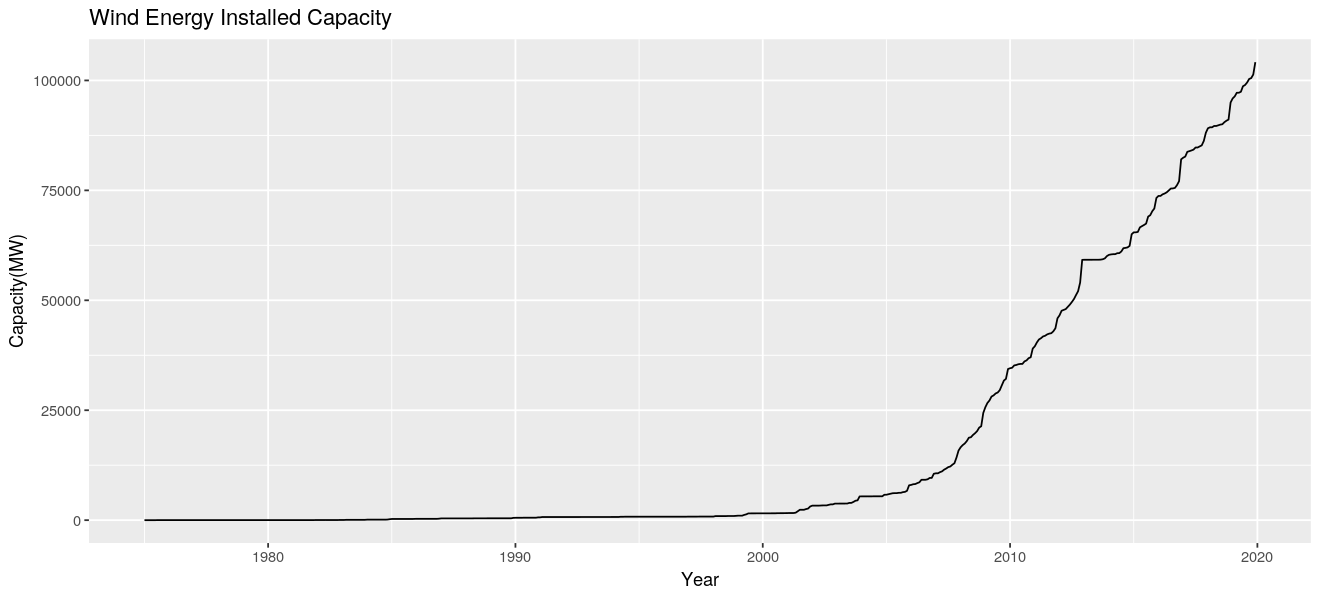

In [32]:
wind_cap_ts <- ts(wind_cap$Cumul.Cap.MW, start = c(first, 1), end = c(last, 12), frequency = 12)
autoplot(wind_cap_ts) + xlab("Year") + ylab("Capacity(MW)") + ggtitle("Wind Energy Installed Capacity")

<h3><u>Solar Energy</u></h3>

In [33]:
solar_cap <- capacity[capacity$Source == "SUN",]
head(solar_cap)

,Name,Sector,State,Capacity.MW,Technology,Source,Operating.Month,Operating.Year,Status
,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<int>,<int>,<fct>
285,Agua Fria,Electric Utility,AZ,0.2,Solar Photovoltaic,SUN,6,2001,(OP) Operating
1107,Big Bend,Electric Utility,FL,19.0,Solar Photovoltaic,SUN,2,2017,(OP) Operating
1557,Geneseo,Electric Utility,IL,1.2,Solar Photovoltaic,SUN,8,2015,(OP) Operating
1632,North Ninth Street,Electric Utility,IL,0.3,Solar Photovoltaic,SUN,11,2014,(OP) Operating
1987,Osage (IA),Electric Utility,IA,0.8,Solar Photovoltaic,SUN,11,2016,(OP) Operating
2350,E W Brown,Electric Utility,KY,10.0,Solar Photovoltaic,SUN,5,2016,(OP) Operating


Group the installed capacity by operating month and year and sum the total capacity for each month/year:

In [34]:
solar_cap <- aggregate(Capacity.MW ~ Operating.Year + Operating.Month, data = solar_cap, FUN = sum)
solar_cap <- solar_cap[order(solar_cap$Operating.Year, solar_cap$Operating.Month),]
head(solar_cap, 10)

,Operating.Year,Operating.Month,Capacity.MW
,<int>,<int>,<dbl>
139,1986,12,68.4
112,1987,10,34.2
140,1988,12,70.0
141,1989,12,92.0
98,1990,9,92.0
46,2001,5,3.7
60,2001,6,0.2
113,2002,10,2.1
22,2003,3,0.2


<br>

The data above provides the capacity of new installations by month and year but what we need is the cumulative installed capacity. In addition, months where no new capacity was added are not included in the original data. For a time-series analysis,these must be added to the series with carry-over values from previous months.

In [35]:
# Create a dataframe with all the months spanning the time period of the series
first <- min(solar_cap$Operating.Year)
last <- 2019
yrs <- data.frame(Operating.Month = rep(1:12, last - first + 1), 
                  Operating.Year = unlist(lapply(c(first:last), function(x) rep(x,12))))
# Left-join the `solar_cap` on the new dataframe to expand to all months
solar_cap <- merge(x = yrs, y = solar_cap, by = c("Operating.Year", "Operating.Month"), all.x = T)
# Replace NA values with 0
solar_cap$Capacity.MW <- replace(solar_cap$Capacity.MW, is.na(solar_cap$Capacity.MW), 0)
# Determine cumulative installed capacity
solar_cap$Cumul.Cap.MW <- cumsum(solar_cap$Capacity.MW)

head(solar_cap, 15)

,Operating.Year,Operating.Month,Capacity.MW,Cumul.Cap.MW
,<int>,<int>,<dbl>,<dbl>
1,1986,1,0.0,0.0
2,1986,2,0.0,0.0
3,1986,3,0.0,0.0
4,1986,4,0.0,0.0
5,1986,5,0.0,0.0
6,1986,6,0.0,0.0
7,1986,7,0.0,0.0
8,1986,8,0.0,0.0
9,1986,9,0.0,0.0


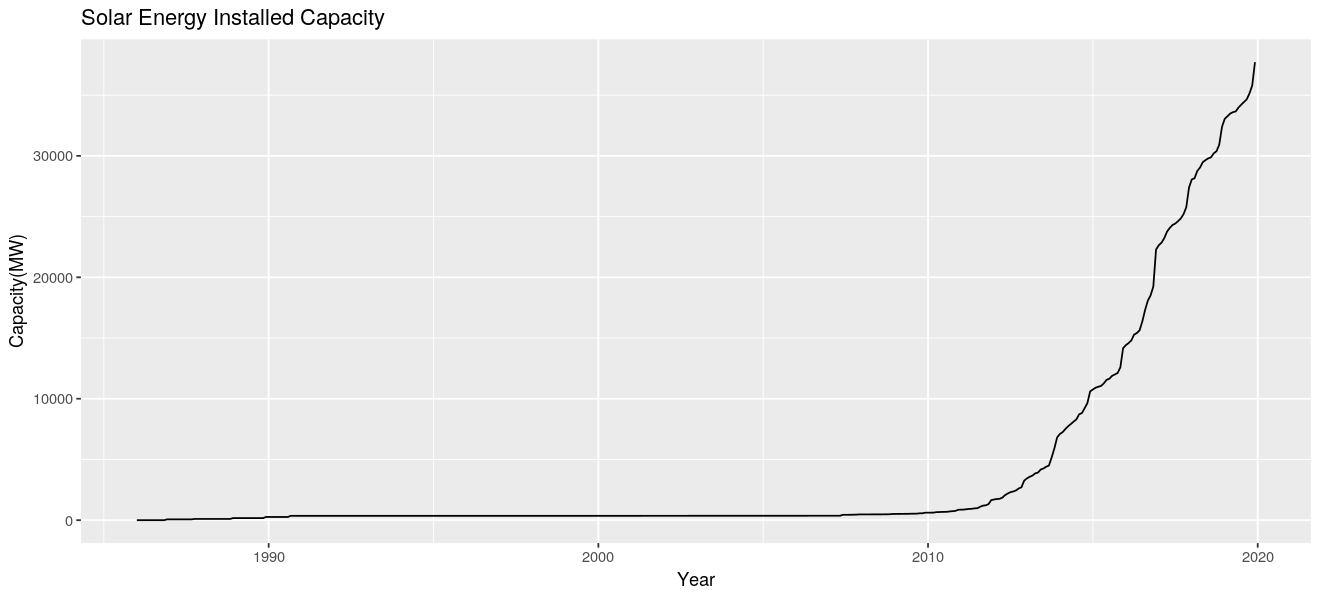

In [36]:
solar_cap_ts <- ts(solar_cap$Cumul.Cap.MW, start = c(first, 1), end = c(last, 12), frequency = 12)
autoplot(solar_cap_ts) + xlab("Year") + ylab("Capacity(MW)") + ggtitle("Solar Energy Installed Capacity")

Comparing wind and solar and plotting out the total:

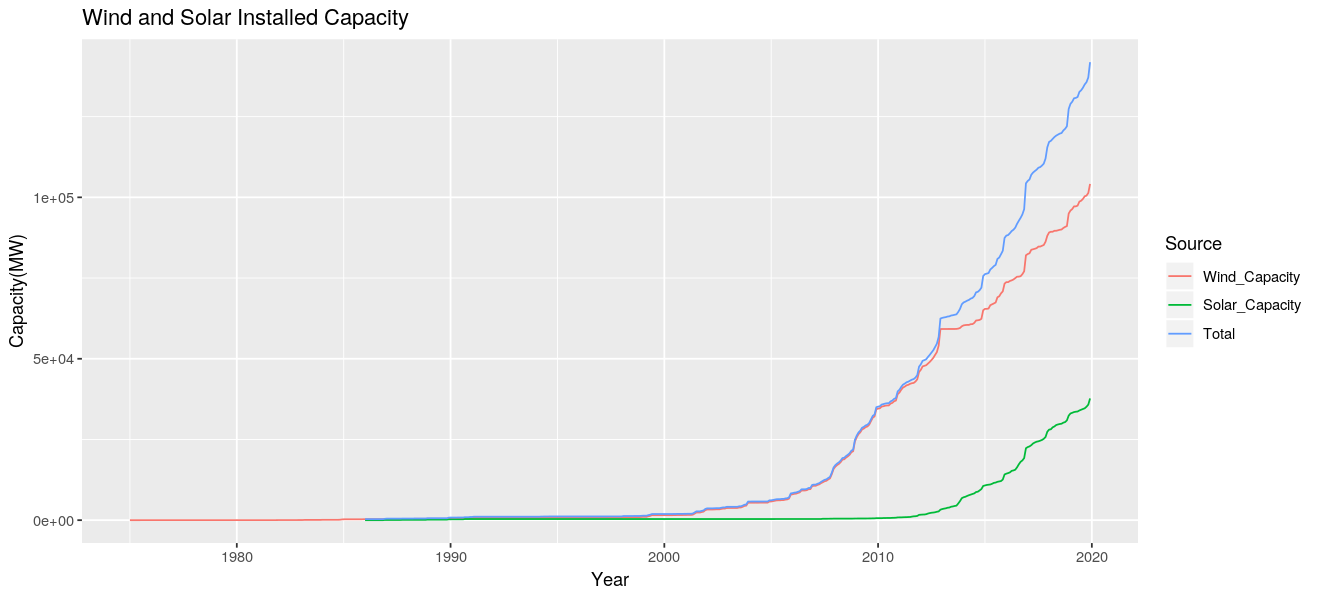

In [37]:
autoplot(cbind(Wind_Capacity = wind_cap_ts, Solar_Capacity = solar_cap_ts, Total = (wind_cap_ts + solar_cap_ts))) + 
    xlab("Year") + ylab("Capacity(MW)") + ggtitle("Wind and Solar Installed Capacity") +
    guides(color = guide_legend(title = "Source"))

<br>

<h3><u>Natural Gas</u></h3>

Natural gas is included as an example of a fossil fuel that provides a large portion of America's energy supply. The widespread adoption of natural gas as a power source really began in the early 2000's with the shale gas boom and continues to grow. It will be interesting to see if the adoption of wind and solar power has affected the growth in natural gas capacity.

In [38]:
ng_cap <- capacity[capacity$Source == "NG",]
head(ng_cap)

,Name,Sector,State,Capacity.MW,Technology,Source,Operating.Month,Operating.Year,Status
,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<int>,<int>,<fct>
2,Barry,Electric Utility,AL,153.1,Natural Gas Steam Turbine,NG,2,1954,(OP) Operating
3,Barry,Electric Utility,AL,153.1,Natural Gas Steam Turbine,NG,7,1954,(OP) Operating
6,Barry,Electric Utility,AL,170.1,Natural Gas Fired Combined Cycle,NG,5,2000,(OP) Operating
7,Barry,Electric Utility,AL,170.1,Natural Gas Fired Combined Cycle,NG,5,2000,(OP) Operating
8,Barry,Electric Utility,AL,195.2,Natural Gas Fired Combined Cycle,NG,5,2000,(OP) Operating
9,Barry,Electric Utility,AL,170.1,Natural Gas Fired Combined Cycle,NG,5,2000,(OP) Operating


Group the installed capacity by operating month and year and sum the total capacity for each month/year:

In [39]:
ng_cap <- aggregate(Capacity.MW ~ Operating.Year + Operating.Month, data = ng_cap, FUN = sum)
ng_cap <- ng_cap[order(ng_cap$Operating.Year, ng_cap$Operating.Month),]
head(ng_cap, 10)

,Operating.Year,Operating.Month,Capacity.MW
,<int>,<int>,<dbl>
1,1915,1,0.6
2,1925,1,15.0
401,1938,7,5.0
3,1939,1,6.6
666,1940,11,6.0
4,1942,1,62.0
5,1943,1,7.5
6,1944,1,6.0
474,1944,8,0.6


<br>

The data above provides the capacity of new installations by month and year but what we need is the cumulative installed capacity. In addition, months where no new capacity was added are not included in the original data. For a time-series analysis,these must be added to the series with carry-over values from previous months.

In [40]:
# Create a dataframe with all the months spanning the time period of the series
first <- min(ng_cap$Operating.Year)
last <- 2019
yrs <- data.frame(Operating.Month = rep(1:12, last - first + 1), 
                  Operating.Year = unlist(lapply(c(first:last), function(x) rep(x,12))))
# Left-join the `ng_cap` on the new dataframe to expand to all months
ng_cap <- merge(x = yrs, y = ng_cap, by = c("Operating.Year", "Operating.Month"), all.x = T)
# Replace NA values with 0
ng_cap$Capacity.MW <- replace(ng_cap$Capacity.MW, is.na(ng_cap$Capacity.MW), 0)
# Determine cumulative installed capacity
ng_cap$Cumul.Cap.MW <- cumsum(ng_cap$Capacity.MW)

head(ng_cap, 15)

,Operating.Year,Operating.Month,Capacity.MW,Cumul.Cap.MW
,<int>,<int>,<dbl>,<dbl>
1,1915,1,0.6,0.6
2,1915,2,0.0,0.6
3,1915,3,0.0,0.6
4,1915,4,0.0,0.6
5,1915,5,0.0,0.6
6,1915,6,0.0,0.6
7,1915,7,0.0,0.6
8,1915,8,0.0,0.6
9,1915,9,0.0,0.6


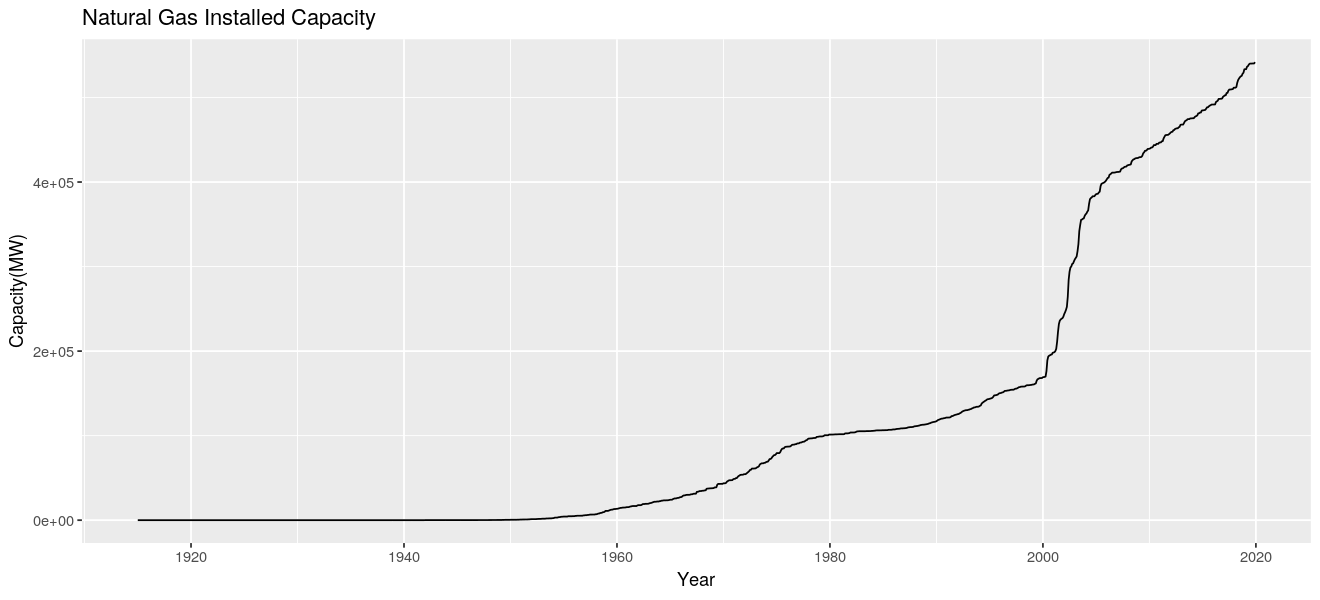

In [41]:
ng_cap_ts <- ts(ng_cap$Cumul.Cap.MW, start = c(first, 1), end = c(last, 12), frequency = 12)
autoplot(ng_cap_ts) + xlab("Year") + ylab("Capacity(MW)") + ggtitle("Natural Gas Installed Capacity")

<br>

<h3><u>Coal</u></h3>

Coal is included as a legacy fossil fuel that still provides a large portion of America's energy supply. It is of interest to see how it compares to solar and wind as well as natural gas.

In [42]:
coal_cap <- capacity[capacity$Technology == "Conventional Steam Coal",]
head(coal_cap)

,Name,Sector,State,Capacity.MW,Technology,Source,Operating.Month,Operating.Year,Status
,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<int>,<int>,<fct>
4,Barry,Electric Utility,AL,403.7,Conventional Steam Coal,BIT,12,1969,(OP) Operating
5,Barry,Electric Utility,AL,788.8,Conventional Steam Coal,BIT,10,1971,(OP) Operating
67,E C Gaston,Electric Utility,AL,952.0,Conventional Steam Coal,BIT,8,1974,(OP) Operating
105,Dolet Hills,Electric Utility,LA,720.7,Conventional Steam Coal,LIG,4,1986,(OP) Operating
120,Charles R Lowman,Electric Utility,AL,66.0,Conventional Steam Coal,BIT,6,1969,(OP) Operating
121,Charles R Lowman,Electric Utility,AL,236.0,Conventional Steam Coal,BIT,6,1978,(OP) Operating


Group the installed capacity by operating month and year and sum the total capacity for each month/year:

In [43]:
coal_cap <- aggregate(Capacity.MW ~ Operating.Year + Operating.Month, data = coal_cap, FUN = sum)
coal_cap <- coal_cap[order(coal_cap$Operating.Year, coal_cap$Operating.Month),]
head(coal_cap, 10)

,Operating.Year,Operating.Month,Capacity.MW
,<int>,<int>,<dbl>
1,1930,1,6.2
271,1936,9,6.0
2,1937,1,7.5
272,1939,9,6.0
3,1941,1,7.5
206,1941,7,6.0
4,1946,1,7.5
46,1946,2,6.0
5,1947,1,3.0


<br>

The data above provides the capacity of new installations by month and year but what we need is the cumulative installed capacity. In addition, months where no new capacity was added are not included in the original data. For a time-series analysis,these must be added to the series with carry-over values from previous months.

In [44]:
# Create a dataframe with all the months spanning the time period of the series
first <- min(coal_cap$Operating.Year)
last <- 2019
yrs <- data.frame(Operating.Month = rep(1:12, last - first + 1), 
                  Operating.Year = unlist(lapply(c(first:last), function(x) rep(x,12))))
# Left-join the `coal_cap` on the new dataframe to expand to all months
coal_cap <- merge(x = yrs, y = coal_cap, by = c("Operating.Year", "Operating.Month"), all.x = T)
# Replace NA values with 0
coal_cap$Capacity.MW <- replace(coal_cap$Capacity.MW, is.na(coal_cap$Capacity.MW), 0)
# Determine cumulative installed capacity
coal_cap$Cumul.Cap.MW <- cumsum(coal_cap$Capacity.MW)

head(coal_cap, 15)

,Operating.Year,Operating.Month,Capacity.MW,Cumul.Cap.MW
,<int>,<int>,<dbl>,<dbl>
1,1930,1,6.2,6.2
2,1930,2,0.0,6.2
3,1930,3,0.0,6.2
4,1930,4,0.0,6.2
5,1930,5,0.0,6.2
6,1930,6,0.0,6.2
7,1930,7,0.0,6.2
8,1930,8,0.0,6.2
9,1930,9,0.0,6.2


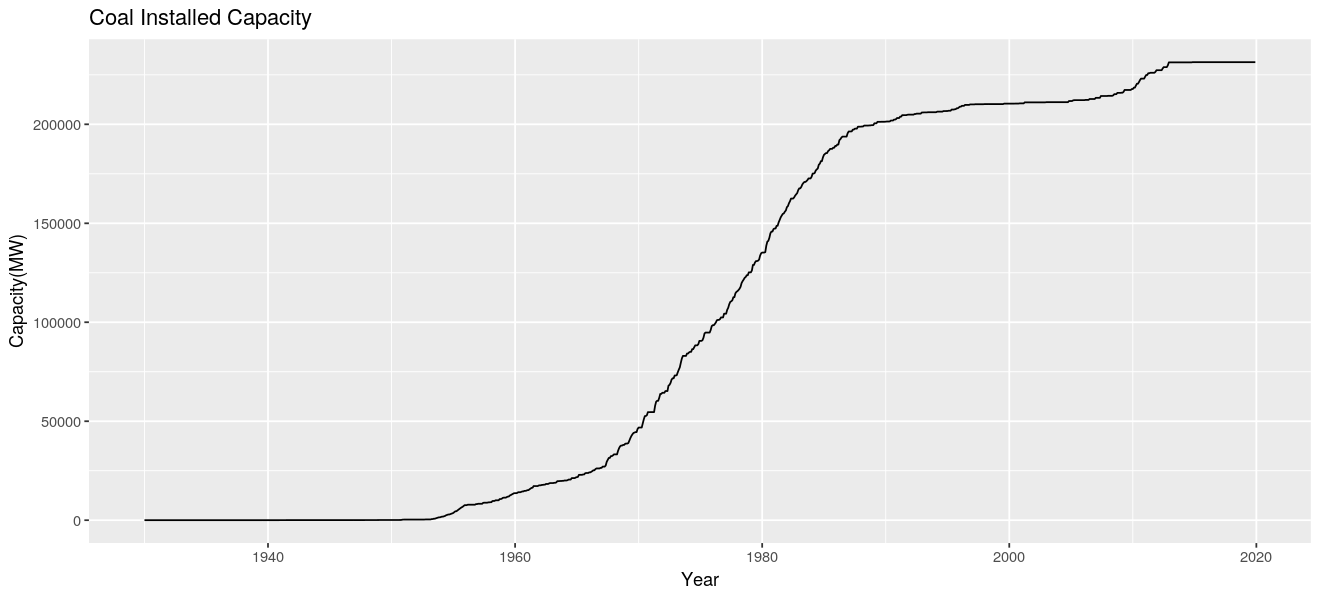

In [45]:
coal_cap_ts <- ts(coal_cap$Cumul.Cap.MW, start = c(first, 1), end = c(last, 12), frequency = 12)
autoplot(coal_cap_ts) + xlab("Year") + ylab("Capacity(MW)") + ggtitle("Coal Installed Capacity")

<br>

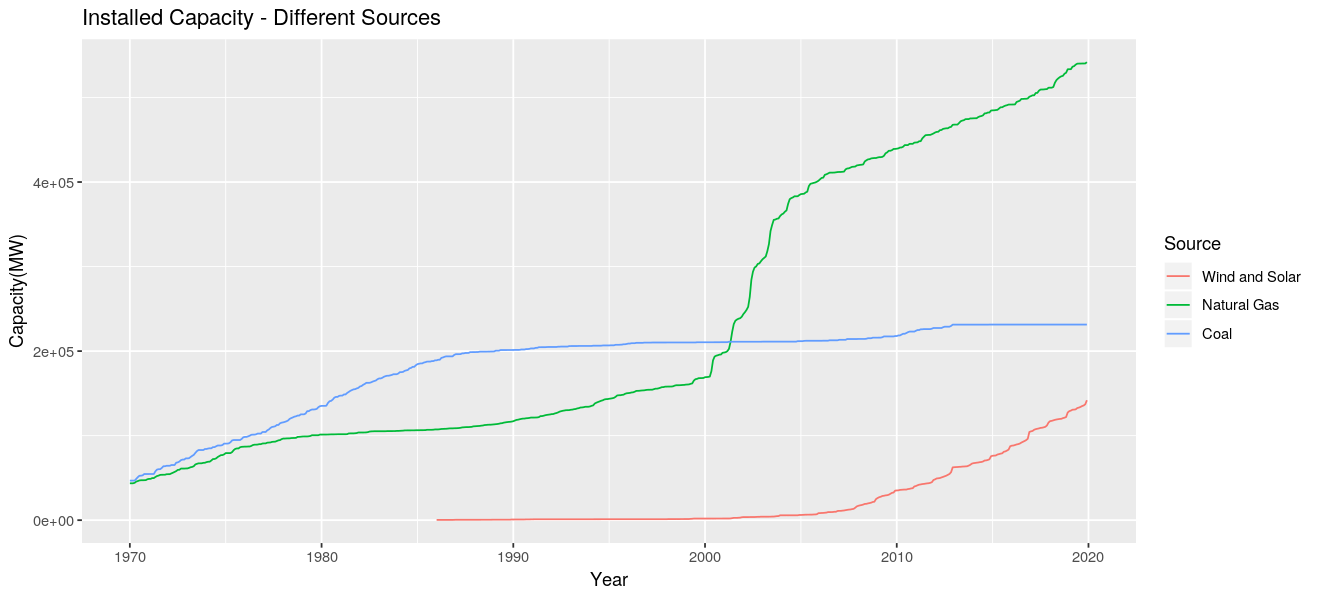

In [46]:
autoplot(cbind("Wind and Solar" = (wind_cap_ts + solar_cap_ts), "Natural Gas" = ng_cap_ts, "Coal" = coal_cap_ts)) + 
    xlab("Year") + ylab("Capacity(MW)") + ggtitle("Installed Capacity - Different Sources") + 
    xlim(c(1970,2020)) + guides(color = guide_legend(title = "Source"))

<h4><u>Save the Data for Reuse</u></h4>

In [47]:
save(capacity, wind_cap, wind_cap_ts, solar_cap, solar_cap_ts, ng_cap, ng_cap_ts, coal_cap, coal_cap_ts, file = "capacity.RData")